In [1]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15101 MiB


Access the pretrained weights with this link
https://drive.google.com/drive/folders/12vZ9cIQ89yR2x8wxRFFdF4g7YB2QLQu5

Add Shortcut to your drive to be able to access it

In [4]:
# @title If the weights are in the drive, connect to the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install Requirements

In [ ]:
!git clone -b dev https://github.com/natelazoyan/Virtual_Influencer.git
!pip install -r https://raw.githubusercontent.com/natelazoyan/Virtual_Influencer/main/difussers/Requirements.txt
!pip install -q accelerate transformers ftfy bitsandbytes==0.41.3 natsort safetensors xformers
!pip install -q diffusers

## Settings and run

In [ ]:
# @markdown Inference to diffusers. Specify the model path.
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = "/content/drive/MyDrive/600" #@param            #this with the full path of model in gdrive where the weights are saved

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
#pipe.enable_xformers_memory_efficient_attention()
g_cuda = None

In [6]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(seed)

  0%|          | 0/24 [00:00<?, ?it/s]

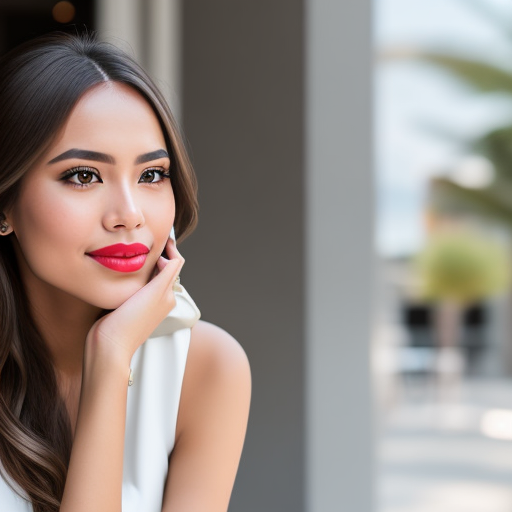

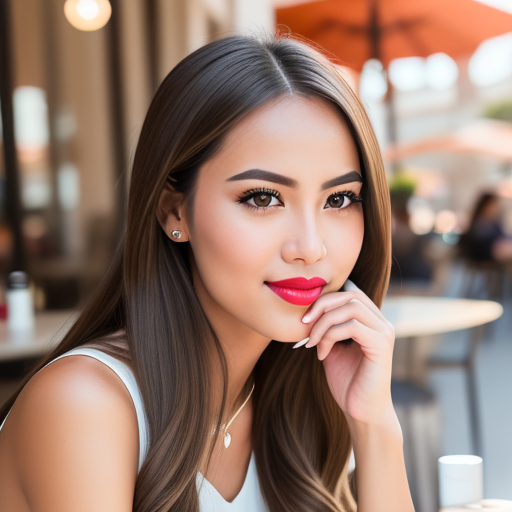

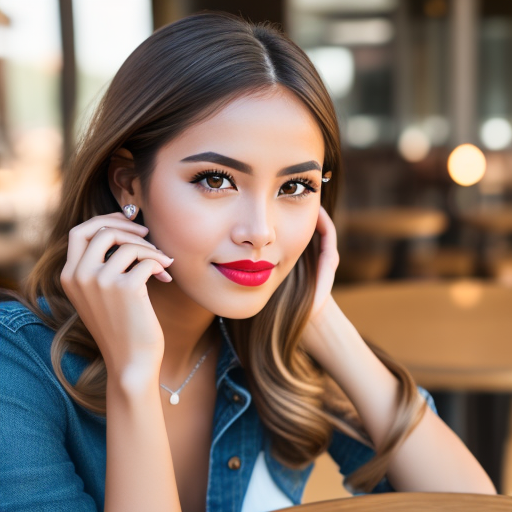

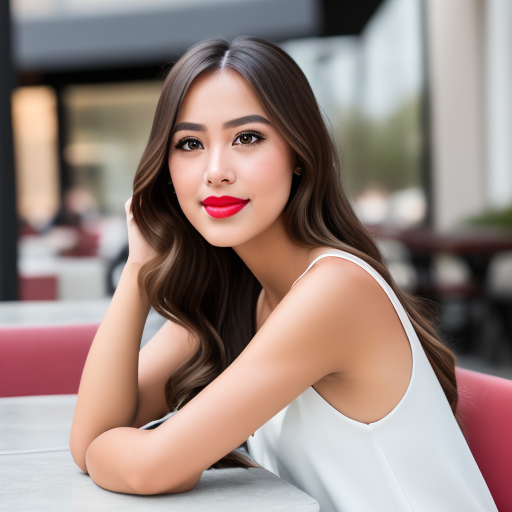

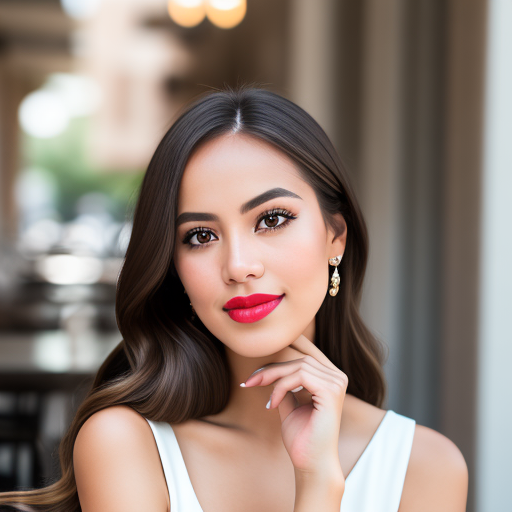

In [8]:
#@title Run for generating images. Make sure to change the prompts.

prompt = "photo of zwx girl, in the cafe, sitting outside with red lipstick, rim lighting, dslr, ultra quality, sharp focus, tack sharp, dof, film grain, Fujifilm XT3, crystal clear, 8K UHD, highly detailed glossy eyes, high detailed skin, skin pore" #@param {type:"string"}
negative_prompt = "rz-neg-15-foranalog, CGI, 3d, lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature" #@param {type:"string"}
num_samples = 5 #@param {type:"number"}
guidance_scale = 8 #@param {type:"number"}
num_inference_steps = 24 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

Computing Image to Image and Text to Image Similarity Scores with CLIP

To access the folder where the outputs were saved follow the link
https://drive.google.com/drive/folders/1w38frUvf3_l8oU36RF-aR1d4L8HPD0Ev?usp=sharing


Generating images from the Prompt list

In [ ]:
# Function to load prompts from a file
def load_prompts(file_path):
    with open(file_path, 'r') as file:
        prompts = file.read().splitlines()
    return prompts

# Generate and display images for each prompt
def generate_images(prompts, num_samples, height, width, negative_prompt, num_inference_steps, guidance_scale):
    image_records = []  # List to store image filenames and prompts

    for prompt in prompts:
        with torch.cuda.amp.autocast(), torch.inference_mode():
            images = pipe(
                prompt=prompt,
                height=height,
                width=width,
                negative_prompt=negative_prompt,
                num_images_per_prompt=num_samples,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale
            ).images

        # Display and optionally save images
        for i, img in enumerate(images):
            plt.figure(figsize=(8, 8))  # Adjust the size of the displayed image
            plt.imshow(img)
            plt.title(f"Prompt: {prompt[:30]}... Image {i+1}")
            plt.axis('off')  # Hide axes
            plt.show()

            # Save the image
            image_filename = f"{prompt[:50].replace('/', '_')}_img_{i}.png"
            img.save(f"/content/drive/MyDrive/CLIP/{image_filename}")

            # Record the filename and prompt
            image_records.append({"Filename": image_filename, "Prompt": prompt})

    # Save records to a CSV file
    df = pd.DataFrame(image_records)
    df.to_csv('/content/drive/MyDrive/CLIP/image_prompt_records.csv', index=False)

# Main execution
if __name__ == "__main__":
    # Load prompts from the specified path
    prompts_path = '/content/drive/MyDrive/CLIP/Prompts.txt'
    prompts = load_prompts(prompts_path)

    # Generate images
    generate_images(
        prompts=prompts,
        num_samples=4,
        height=512,
        width=512,
        negative_prompt="deformed body parts, ((deformed face)), more than 2 hands, multiple feet, multiple legs, too dark, (deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime, mutated hands and fingers:1.4), (deformed, distorted, disfigured:1.3), poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, disconnected limbs, mutation, mutated, ugly, disgusting, amputation",
        num_inference_steps=24,
        guidance_scale=8
    )


Computing Image to Image, and Prompt to Image scores



In [ ]:
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import matplotlib.pyplot as plt
import os


# Function to compute similarity
def compute_similarity(model, processor, image_path, text_prompt, reference_image_path):
    device = model.device
    image = Image.open(image_path).convert("RGB")
    # Ensure that the text prompt is a string
    text_prompt = str(text_prompt)  # Ensure text prompt is a string
    inputs = processor(text=[text_prompt], images=[image], return_tensors="pt", padding=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        image_embeddings = outputs.image_embeds
        text_embeddings = outputs.text_embeds

    text_sim = torch.nn.functional.cosine_similarity(image_embeddings, text_embeddings, dim=1).item()

    if reference_image_path:
        ref_image = Image.open(reference_image_path).convert("RGB")
        ref_inputs = processor(images=[ref_image], return_tensors="pt", padding=True)
        ref_inputs = {key: val.to(device) for key, val in ref_inputs.items()}
        with torch.no_grad():
            ref_outputs = model.get_image_features(**ref_inputs)
        ref_sim = torch.nn.functional.cosine_similarity(image_embeddings, ref_outputs, dim=1).item()
        return text_sim, ref_sim

def process_similarity(csv_path, reference_image_path, output_csv_path):
    # Load CSV with image names and prompts
    df = pd.read_csv(csv_path)

    # Initialize CLIP model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    results = []

    for _, row in df.iterrows():
        image_path = f"/content/drive/MyDrive/CLIP/{row['Filename']}"
        prompt = row['Prompt']
        text_sim, ref_sim = compute_similarity(model, processor, image_path, prompt, reference_image_path)
        results.append({
            "Image": row['Filename'],
            "Prompt": prompt,
            "Text Similarity": text_sim,
            "Reference Image Similarity": ref_sim
        })

    # Save results to a new CSV file
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}")

# Example call
csv_path = '/content/drive/MyDrive/CLIP/image_prompt_records.csv'
reference_image_path = '/content/drive/MyDrive/CLIP/noa2.jpg'
output_csv_path = '/content/drive/MyDrive/CLIP/similarity_results.csv'
process_similarity(csv_path, reference_image_path, output_csv_path)
